Python library imported in code

In [1]:
import os
import numpy as np
import csv
from itertools import product
from sklearn.cluster import KMeans
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from matplotlib import pyplot as plt
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt

In [ ]:
#function to check that character can only be A T G C
valid_chars={'A','T','G','C'}
def check_data_validity(str):
  for j in str:
    if j not in valid_chars:
      return False
  return True


In [56]:
#Preprocessing of data with data redudancy in same file and extracting protein sequence from raw data
folder_path = "ATGC"

with open("Preprocessed_data_file/proteinSequence.txt", "w") as out_file:
    for file_name in os.listdir(folder_path):
            file_path = os.path.join(folder_path, file_name)
            seen_sequence={}
            str_data=""
            with open(file_path, "r") as f:
                
                for line in f:
                    line=line.strip()
                    if len(line)>0 and line[0]=='>':
                      if len(str_data)>0:
                          if str_data not in seen_sequence:
                            seen_sequence[str_data]=True
                            if check_data_validity(str_data):
                              out_file.write(f"{str_data}\n")
                            str_data=""
                      continue
                    str_data=str_data+line
                
                if len(str_data)>0:
                          if str_data not in seen_sequence:
                            seen_sequence[str_data]=True
                            if check_data_validity(str_data):
                              out_file.write(f"{str_data}\n")
                            str_data=""
  
               


Divide nucleotide bases into its category on basis of chemical properties

In [57]:

MK={'A':'M','C':'M','G':'K','T':'K'}
def MK_group(str):
  temp_str=""
  for j in str:
    temp_str+=MK[j]
  return temp_str

  


In [58]:
RY={'A':'R','C':'Y','G':'R','T':'Y'}
def RY_group(str):
  temp_str=""
  for j in str:
    temp_str+=RY[j]
  return temp_str

In [59]:
WS={'A':'W','C':'S','G':'S','T':'W'}
def WS_group(str):
  temp_str=""
  for j in str:
    temp_str+=WS[j]
  return temp_str

In [61]:
#window size
k=2


Creating original sequence

In [62]:

def create_original_sequence(str,group):
    a=np.array([],dtype=float)
    length_of_str=len(str)
    for i in range(k,length_of_str+1):
        if str[i-k:i]==group:
            a=np.append(a,1)
        else:
            a=np.append(a,0)
    return a
    
    

Creating local frequency sequence

In [63]:
def create_local_frequency_sequence(original_sequence):
    length_of_array=len(original_sequence)
    prev_ind=0
    for i in range(1,length_of_array+1):
        if original_sequence[i-1]==1:
            original_sequence[i-1]=1/(i-prev_ind)
            prev_ind=i

    

Creating Local Frequency based partial sum sequence 

In [64]:
def create_LF_based_partial_sum_sequence(LF_sequence):
    length_of_array=len(LF_sequence)
    for i in range(1,length_of_array):
        LF_sequence[i]+=LF_sequence[i-1]

Calculating Local Frequency based entropy value

In [65]:
def create_LF_based_entropy_value(a):
    sol=0.0
    Z=0.0
    for j in a:
        Z+=j
    if Z==0:
        return 0
    
    for j in a:
        pr=j/Z
        if pr!=0:
            sol-=(pr*np.log2(pr))
    return sol
    

Generating Possible Groups based on window size

In [66]:


def generate_possible_group(char_arr):
    a=[]
    for i in range(0,k):
        a.append(char_arr)
    combs=product(*a)
    possible_string=np.array([],dtype='str')
    for j in combs:
        temp_str=''.join(j)
        possible_string=np.append(possible_string,temp_str)
    return possible_string
possible_groups_MK=generate_possible_group(('M','K'))
possible_groups_RY=generate_possible_group(('R','Y'))
possible_groups_WS=generate_possible_group(('W','S'))

Generating Feature Vector and storing in a CSV file

In [68]:
folder_path="Preprocessed_data_file"
with open('Feature_Vector/feature_vector.csv','w') as csv_file:
    writer=csv.writer(csv_file)
    for file_name in os.listdir(folder_path):
        file_path = os.path.join(folder_path, file_name)    
        with open(file_path,"r") as f:
            for line in f:
                feature_vector=np.array([],dtype=float)
                line = line.rstrip("\n") 
                #for MK
                MK_sequence=MK_group(line)
                for group in possible_groups_MK:                  
                    original_sequence=create_original_sequence(MK_sequence,group)
                    create_local_frequency_sequence(original_sequence)
                    create_LF_based_partial_sum_sequence(original_sequence)
                    LF_based_entropy_value=create_LF_based_entropy_value(original_sequence)
                    feature_vector=np.append(feature_vector,LF_based_entropy_value)
                #for RY
                RY_sequence=RY_group(line)
                for group in possible_groups_RY:                  
                    original_sequence=create_original_sequence(RY_sequence,group)
                    create_local_frequency_sequence(original_sequence)
                    create_LF_based_partial_sum_sequence(original_sequence)
                    LF_based_entropy_value=create_LF_based_entropy_value(original_sequence)
                    feature_vector=np.append(feature_vector,LF_based_entropy_value)
 
                #for WS
                WS_sequence=WS_group(line)
                for group in possible_groups_WS:                  
                    original_sequence=create_original_sequence(WS_sequence,group)
                    create_local_frequency_sequence(original_sequence)
                    create_LF_based_partial_sum_sequence(original_sequence)
                    LF_based_entropy_value=create_LF_based_entropy_value(original_sequence)
                    feature_vector=np.append(feature_vector,LF_based_entropy_value)  
                
                writer.writerow(feature_vector)
                    

      


Additional code to combined multiple file in case if we want to run on multiple system and combine the extracted feature vector

In [31]:
folder_path="Part_wise_feature_vector"


combined_df = pd.DataFrame()
for file_name in os.listdir(folder_path):
    if file_name.endswith('.csv'):
        temp_df = pd.read_csv(os.path.join(folder_path,file_name), header=None)
        print(temp_df.shape)
        combined_df =pd.concat([combined_df,temp_df])
        #combined_df.append(temp_df,ignore_index=True)
    


print(combined_df.shape)

combined_df.to_csv('Feature_Vector/feature_vector.csv', index=False)

(79143, 12)
(64270, 12)
(77753, 12)
(55815, 12)
(67660, 12)
(344641, 12)


Reading from CSV file and ignoring the header value

In [2]:
feature_vector=pd.read_csv("Feature_Vector/feature_vector.csv",header=None)

Applying K-Means clustering algorithm and using Silhouette Function to compare for different value of K

In [3]:
silhouette_data=[]

In [8]:
for num_of_cluster in range(2,11):
    km=KMeans(n_clusters=num_of_cluster,random_state=354, max_iter=10)
    y_predicted = km.fit_predict(feature_vector)
    silhouette_avg=silhouette_score(feature_vector,y_predicted)
    silhouette_data.append([num_of_cluster,silhouette_avg])

In [9]:
silhouette_data

[[2, 0.5552224682033385],
 [3, 0.5292249442788798],
 [4, 0.5133423165538097],
 [5, 0.503286466610789],
 [6, 0.4948436896420247],
 [7, 0.49888948454943416],
 [8, 0.4906262061450674],
 [9, 0.4844882520736687],
 [10, 0.47241747164030673]]

Pictorial Representation of Silhouette Score obtained on different K

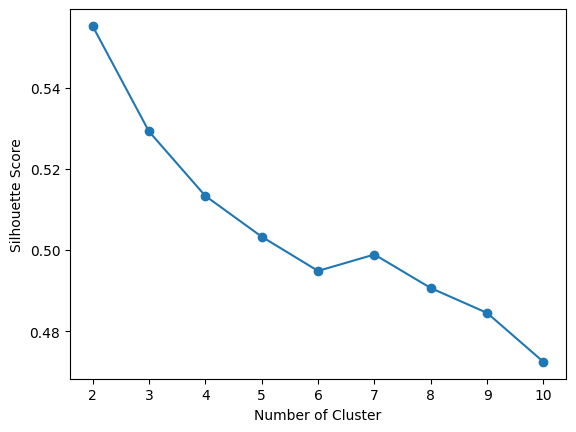

In [10]:
x = [row[0] for row in silhouette_data]
y = [row[1] for row in silhouette_data]
plt.xlabel('Number of Cluster')
plt.ylabel('Silhouette Score')
plt.plot(x,y,'o-')
plt.show()

In [77]:
# km=KMeans(n_clusters=3,random_state=8853, max_iter=1000)
# km

In [78]:
# y_predicted = km.fit_predict(df)
# y_predicted

In [79]:
# centroids=km.cluster_centers_
# centroids

In [80]:
# silhouette_avg=silhouette_score(df, y_predicted)
# silhouette_avg